This notebook only contains the code used for the report. Please refer to the full report for the presentation of the problem and all the details regarding the approach followed to solve it.

## Auxiliary Functions

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns

def CustomCmap(from_rgb,to_rgb):

    # from color r,g,b
    r1,g1,b1 = from_rgb

    # to color r,g,b
    r2,g2,b2 = to_rgb

    cdict = {'red': ((0, r1, r1),
                   (1, r2, r2)),
           'green': ((0, g1, g1),
                    (1, g2, g2)),
           'blue': ((0, b1, b1),
                   (1, b2, b2))}

    cmap = LinearSegmentedColormap('custom_cmap', cdict)
    return cmap

mycmap = CustomCmap([227/255, 229/255, 232/255], [39/255, 61/255, 99/255])

mycol = (72/255, 99/255, 147/255)
mycomplcol = (129/255, 143/255, 163/255)

## Introduction & Basic Statistics

In [2]:
import pandas as pd
import matplotlib
import numpy as np

sns.set(style = "darkgrid")

In [3]:
# The data are located in a local folder
filepath = 'driving.csv'
df = pd.read_csv(filepath)

In [4]:
df.describe()

,NewAccelX,NewAccelY,NewAccelZ,NewRotRateX,NewRotRateY,NewRotRateZ,locationSpeed
count,103891.000000,103891.000000,103891.000000,103891.000000,103891.000000,103891.000000,103891.000000
mean,-0.000079,0.000867,0.009910,-0.000357,-0.000180,0.000291,16.333149
std,0.058077,0.060980,0.063359,0.134682,0.128994,0.146620,12.691258
min,-1.322000,-2.163000,-1.415000,-9.102000,-12.628000,-13.615000,0.000000
25%,-0.022000,-0.022000,-0.015000,-0.013000,-0.013000,-0.010000,6.040000
50%,0.000000,0.001000,0.011000,0.000000,0.000000,0.000000,13.080000
75%,0.022000,0.024000,0.035000,0.013000,0.013000,0.010000,29.000000
max,1.224000,1.033000,1.185000,7.147000,7.212000,6.953000,47.660000


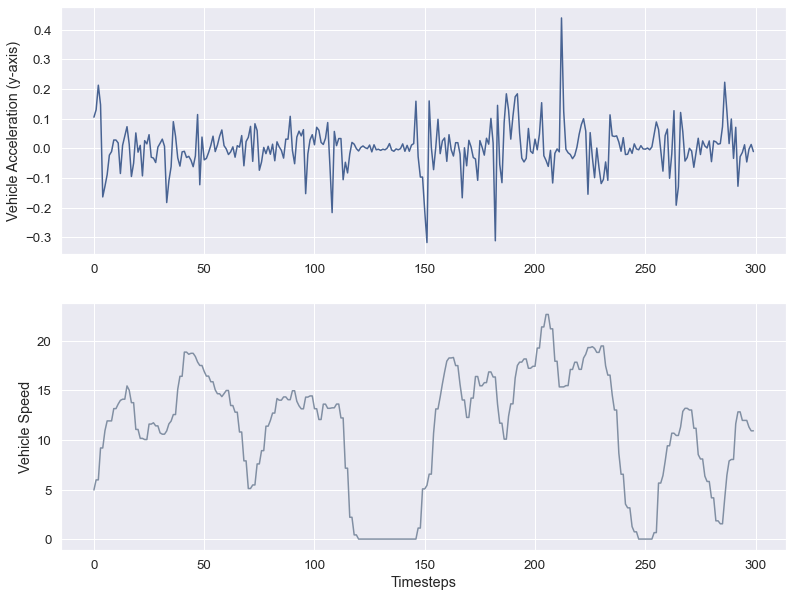

In [5]:
# Check if NewAccelY is consistent with locationSpeed
sns.set(font_scale=1.2)
fig, ax = plt.subplots(2,1,figsize=(13,10))

ran_start = 12
samples = 300
value1 = df['NewAccelX'][ran_start*samples:(ran_start+1)*samples]
value2 = df['locationSpeed'][ran_start*samples:(ran_start+1)*samples]
times = range(samples)
series1 = sns.lineplot(x=times, y=value1, ax=ax[0], color=mycol)
series2 = sns.lineplot(x=times, y=value2, ax=ax[1], color=mycomplcol)

ax[0].set_ylabel('Vehicle Acceleration (y-axis)')
ax[1].set_ylabel('Vehicle Speed')
ax[1].set_xlabel('Timesteps')

plt.savefig("feat_corr.pdf", bbox_inches='tight')
plt.show()

In [6]:
# Keeping only relevant features
df = df.drop(columns=['NewAccelY', 'NewAccelZ', 'NewRotRateX', 'NewRotRateY', 'NewRotRateZ', 'locationSpeed'])

# Initialize the counter for all records to 0
df['label1'] = 0
df['label2'] = 0
df['label3'] = 0
df['counter'] = 0

## Method 1 - Peak Detection

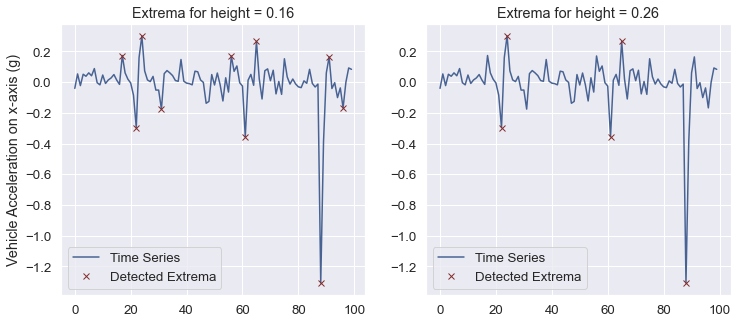

In [7]:
from scipy.signal import find_peaks

the_vals = df['NewAccelX'].values

ran_start = 26
samples = 100
cust_rang = range(ran_start*samples,(ran_start+1)*samples)

# Keep the absolute values at the specified range
sample_peaks = abs(the_vals[cust_rang])

heights = [0.16,0.26]

peaks0, _ = find_peaks(sample_peaks, height=heights[0])
peaks1, _ = find_peaks(sample_peaks, height=heights[1])

sns.set(font_scale=1.2)
fig, ax = plt.subplots(1,2,figsize=(12,5))

# Plot the timeseries window
ax[0].plot(the_vals[cust_rang], color=mycol, label='Time Series')
ax[1].plot(the_vals[cust_rang], color=mycol, label='Time Series')

# Plot the peaks in each case
ax[0].plot(peaks0, the_vals[cust_rang][peaks0], "x", color='#842c2c', label='Detected Extrema')
ax[1].plot(peaks1, the_vals[cust_rang][peaks1], "x", color='#842c2c', label='Detected Extrema')

ax[0].set_title(f'Extrema for height = {heights[0]}')
ax[1].set_title(f'Extrema for height = {heights[1]}')

ax[0].set_ylabel('Vehicle Acceleration on x-axis (g)')

ax[0].legend(loc='best')
ax[1].legend(loc='best')

plt.savefig("peaks_example.pdf", bbox_inches='tight')
plt.show()

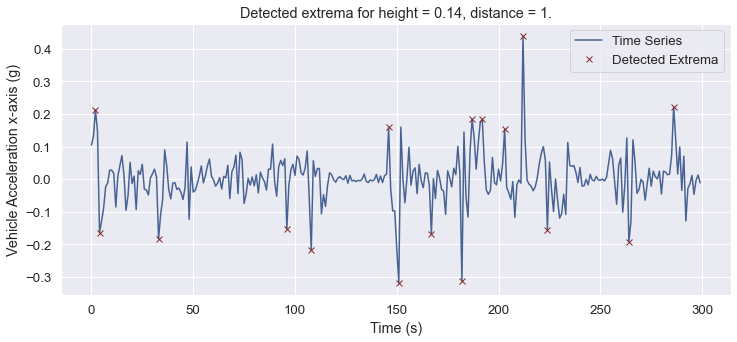

In [8]:
ran_start = 12
samples = 300
cust_rang = range(ran_start*samples,(ran_start+1)*samples)

fig, ax = plt.subplots(1,1,figsize=(12,5))

sample_peaks = abs(the_vals[cust_rang])

# Configurations
height = 0.14
distance = 1

peaks, _ = find_peaks(sample_peaks, height=height, distance=distance)

ax.plot(the_vals[cust_rang], color=mycol, label='Time Series')
ax.plot(peaks, the_vals[cust_rang][peaks], "x", color='#842c2c', label='Detected Extrema')

ax.set_title(f'Detected extrema for height = {height}, distance = {distance}.')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Vehicle Acceleration x-axis (g)')

ax.legend(loc='best')

plt.savefig("peaks_configured.pdf", bbox_inches='tight')
plt.show()

In [9]:
# Locate all peaks
all_peaks, _ = find_peaks(abs(the_vals), height=height, distance=distance) # configure this

# Set the label1 value to 1 for all the peak locations
df.loc[all_peaks, 'label1'] = 1
df.loc[all_peaks, 'counter'] += 1

## Method 2 - Elliptic Envelope

In [10]:
# Extract the mean and standard deviation of the data
mu, sigma = the_vals.mean(), the_vals.std()

# Generate values from N(mu,sigma)
normvals = np.random.normal(loc=mu, scale=sigma, size=len(the_vals))

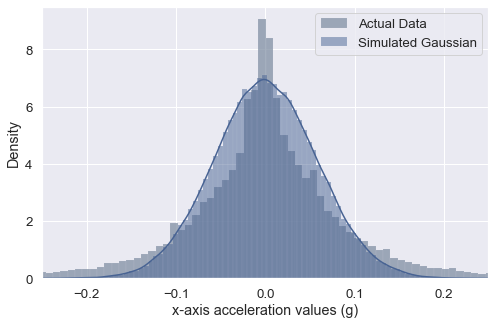

In [11]:
# Explain why it is reasonable to use this
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

#sns.histplot(ax=ax, x=2*the_vals, kde=False, stat="density", bins=620, color=mycomplcol, label='Actual Data')
sns.histplot(ax=ax, x=the_vals, kde=False, stat="density", bins=100, color=mycomplcol, label='Actual Data')
sns.histplot(ax=ax, x=normvals, kde=True, stat="density", bins=100, color=mycol, label='Simulated Gaussian')

ax.set_xlim(-0.25,0.25)
ax.set_xlabel('x-axis acceleration values (g)')
ax.legend()

plt.savefig("distribs.pdf", bbox_inches='tight')
plt.show()

In [12]:
# Move on to the application of the algorithm
from sklearn.covariance import EllipticEnvelope

# The contamination is estimated by slightly overestimating the
# results from the peak detection algorithm
contamination = len(all_peaks)/df.shape[0]

ElEnv = EllipticEnvelope(random_state=0, contamination=1.1*contamination).fit(the_vals.reshape(-1, 1))
preds = ElEnv.predict(the_vals.reshape(-1, 1))
# Outliers receive the -1 index
elenv_out = (preds == -1)

# Increase their counter by 1
df.loc[elenv_out, 'label2'] = 1
df.loc[elenv_out, 'counter'] += 1

## Method 3 - ECOD

In [13]:
from pyod.models import ecod

ecod_model = ecod.ECOD(contamination=1.1*contamination).fit(the_vals.reshape(-1, 1))
ecod_preds = ecod_model.predict(the_vals.reshape(-1, 1))
# Outliers receive the 1 index
ecod_out = (ecod_preds == 1)

# Increase their counter by 1
df.loc[ecod_out, 'label3'] = 1
df.loc[ecod_out, 'counter'] += 1

In [14]:
lowest_conf = ecod_model.decision_scores_[ecod_out].min()
print(f'The lowest confidence of an outlier detection is {lowest_conf:.3f}.')

The lowest confidence of an outlier detection is 4.334.


## Final Results

In [15]:
one_out = (df['label1']==1).sum()
two_out = (df['label2']==1).sum()
three_out = (df['label3']==1).sum()

one_two_agree = ((df['label1']==1) & (df['label2']==1)).sum()
one_three_agree = ((df['label1']==1) & (df['label3']==1)).sum()
two_three_agree = ((df['label2']==1) & (df['label3']==1)).sum()

final_condition = df['counter'] > 1
total_outliers = final_condition.sum()

print(f'The peak detection algorithm finds a total of {one_out} outliers.')
print(f'The Elliptic Envelope algorithm finds a total of {two_out} outliers.')
print(f'The ECOD algorithm finds a total of {three_out} outliers.')
print('\n')
print(f'The peak detection and Elliptic Envelope algorithms agree on {one_two_agree} outliers.')
print(f'The peak detection and ECOD algorithms agree on {one_three_agree} outliers.')
print(f'The Elliptic Envelope and ECOD algorithms agree on {two_three_agree} outliers.')
print('\n')
print(f'The total number of outliers (by majority vote) is {total_outliers} records, i.e. {(total_outliers/df.shape[0])*100:.2f}% of the dataset.')

The peak detection algorithm finds a total of 2490 outliers.
The Elliptic Envelope algorithm finds a total of 2720 outliers.
The ECOD algorithm finds a total of 2725 outliers.


The peak detection and Elliptic Envelope algorithms agree on 2016 outliers.
The peak detection and ECOD algorithms agree on 2020 outliers.
The Elliptic Envelope and ECOD algorithms agree on 2705 outliers.


The total number of outliers (by majority vote) is 2735 records, i.e. 2.63% of the dataset.


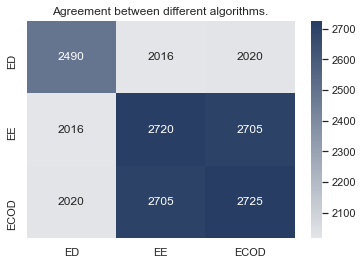

In [16]:
sns.set(font_scale=1.0)

cmat = [[one_out, one_two_agree, one_three_agree],
         [one_two_agree, two_out, two_three_agree],
         [one_three_agree, two_three_agree, three_out]]

df_cm = pd.DataFrame(cmat, index = [i for i in ['ED', 'EE', 'ECOD']],
                  columns = [i for i in ['ED', 'EE', 'ECOD']])
                             
fig, ax = plt.subplots(1,1)

sns.heatmap(ax=ax,data=df_cm, annot=True, cmap=mycmap, fmt='g')
ax.set_title('Agreement between different algorithms.')

plt.savefig("cmat.pdf", bbox_inches='tight')
plt.show()

In [17]:
# Export the results in a .csv file
df['outlier'] = 0
df.loc[final_condition, 'outlier'] = 1

# outliers correspond to a value of 1, the rest records correspond to a value of 0
outliers = df.drop(columns=['NewAccelX', 'label1', 'label2', 'label3', 'counter'])
outliers.to_csv('results.csv', index=False)